In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from keras.metrics import Recall
from keras.metrics import Accuracy

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
df = pd.read_csv('clean_sql_dataset.csv')

In [4]:
df.head()

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148339 entries, 0 to 148338
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Query   148338 non-null  object
 1   Label   148339 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [6]:
df.dropna(inplace=True)

In [7]:
X=df['Query']
y=df['Label']

In [8]:
max_words = len(list(X.str.split(' ', expand=True).stack().unique()))
max_words

612147

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
max_words = 612147
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [11]:
from keras.models import Sequential
model = Sequential()
model.add(Embedding(max_words,100,input_length=max_len))
model.add(LSTM(64))
model.add(Dense(1,activation="sigmoid"))
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 100)          61214700  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 61257005 (233.68 MB)
Trainable params: 61257005 (233.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



In [12]:
model.fit(sequences_matrix,y_train,batch_size=128,epochs=20,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/20


742/742 [==============================] - 417s 557ms/step - loss: 0.1383 - accuracy: 0.9600 - val_loss: 0.0446 - val_accuracy: 0.9887
Epoch 2/20
742/742 [==============================] - 413s 557ms/step - loss: 0.0430 - accuracy: 0.9890 - val_loss: 0.0456 - val_accuracy: 0.9886


In [13]:
X_test_sequences = tok.texts_to_sequences(X_test)
X_test_sequences_matrix = sequence.pad_sequences(X_test_sequences,maxlen=max_len)

In [14]:
accuracy = model.evaluate(X_test_sequences_matrix,y_test)

928/928 [==============================] - 27s 29ms/step - loss: 0.0471 - accuracy: 0.9881


In [15]:
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

Test set
 Loss: 0.047
 Accuracy: 0.988


In [16]:
y_pred=model.predict(X_test_sequences_matrix)

928/928 [==============================] - 27s 28ms/step


In [17]:
print(y_pred)

[[0.9998339 ]
 [0.99982435]
 [0.99950606]
 ...
 [0.99988645]
 [0.00654137]
 [0.00391452]]


In [18]:
for i in range(len(y_pred)):
    if y_pred[i]>0.5:
        y_pred[i]=1
    elif y_pred[i]<=0.5:
        y_pred[i]=0

In [19]:
print(y_pred)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [0.]
 [0.]]


In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
confusion_matrix(y_test, y_pred)  
plt.show()
accuracy= accuracy_score(y_test, y_pred)
precision= precision_score(y_test, y_pred, zero_division=1)
recall= recall_score(y_test, y_pred, zero_division=1)
f1_score= f1_score(y_test, y_pred, zero_division=1)
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2} \n F1 : {3}".format(accuracy, precision, recall, f1_score))

 Accuracy : 0.9881016583524336 
 Precision : 0.9965104029496972 
 Recall : 0.9805636540330418 
 F1 : 0.9884727165855729


In [21]:
from keras.models import load_model
from pathlib import Path

model.save_weights("lstm_weights_bigdatasetRNNUpdatedData.h5")
print('done')

model.save('lstm_model_bigdatasetRNNUpdatedData.h5')

done


C:\Users\Huang\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
loaded_model = tf.keras.models.load_model('lstm_model_bigdatasetRNNUpdatedData.h5')
loaded_model.load_weights('lstm_weights_bigdatasetRNNUpdatedData.h5')

In [23]:
def clean_data(input_val):

    txts = tok.texts_to_sequences(input_val)
    input_val = sequence.pad_sequences(txts, maxlen=max_len)

    return input_val


def predict_sqli_attack():
    
    repeat=True
    
    space=''
    for i in range(20):
        space+= "-"

    print(space) 
    input_val=input("Please enter some data: ")
    print(space)

    
    if input_val== '0':
        repeat=False
    
    sample_texts_list = []
    sample_texts_list.append(input_val)
    txts = tok.texts_to_sequences(sample_texts_list)
    txts = sequence.pad_sequences(txts, maxlen=max_len)

    result=loaded_model.predict(txts)
    print(result)


    print(space)
    
    
    if repeat == True:
            if result > 0.5:
                 print("ALERT! This can be SQL injection")
            elif result <= 0.5:
                 print("It seems to be a benign")
            
            print(space)
        
            predict_sqli_attack()
            
    elif repeat == False:
        print( " Closing ")

In [24]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[14180    53]
 [  300 15135]]


<Axes: >

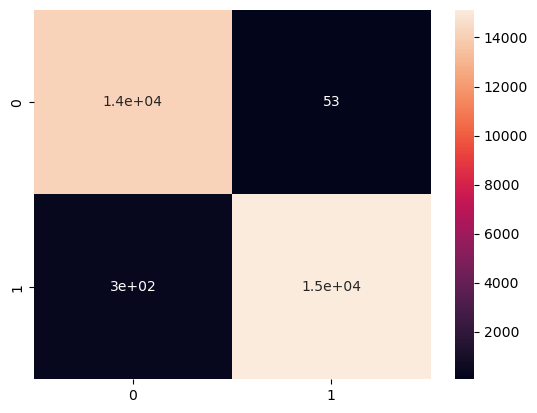

In [25]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [26]:
y_pred.shape

(29668, 1)

In [27]:
predict_sqli_attack()

--------------------
Please enter some data: '
--------------------
1/1 [==============================] - 1s 659ms/step
[[0.0762651]]
--------------------
It seems to be a benign
--------------------
--------------------
Please enter some data: "
--------------------
1/1 [==============================] - 0s 45ms/step
[[0.03774608]]
--------------------
It seems to be a benign
--------------------
--------------------
Please enter some data: ball or apple
--------------------
1/1 [==============================] - 0s 45ms/step
[[0.06675916]]
--------------------
It seems to be a benign
--------------------
--------------------
Please enter some data: id=100'
--------------------
1/1 [==============================] - 0s 44ms/step
[[0.01428785]]
--------------------
It seems to be a benign
--------------------
--------------------
Please enter some data: 0
--------------------
1/1 [==============================] - 0s 27ms/step
[[0.36676928]]
--------------------
 Closing 
